## Load training dataset into pandas dataframe

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#training  = pd.read_table("mediaeval-2015-trainingset.txt")
#testing = pd.read_table("mediaeval-2015-testset.txt")
#training = pd.DataFrame(columns = ['tweetId', 'tweetText', 'userId', 'imageId(s)', 'username', 'timestamp', 'label'])
rows_list = []
with open('mediaeval-2015-trainingset.txt', 'r', encoding="utf-8") as file:
    for line in file:
        entry = [l.strip() for l in line.split('\t')]
        rows_list.append(entry)
training = pd.DataFrame(rows_list[1:], columns = rows_list[0])
training.head()

tweetId                                          tweetText  \
0  263046056240115712  ¿Se acuerdan de la película: “El día después d...   
1  262995061304852481  @milenagimon: Miren a Sandy en NY!  Tremenda i...   
2  262979898002534400  Buena la foto del Huracán Sandy, me recuerda a...   
3  262996108400271360     Scary shit #hurricane #NY http://t.co/e4JLBUfH   
4  263018881839411200  My fave place in the world #nyc #hurricane #sa...   

      userId      imageId(s)        username                       timestamp  \
0   21226711  sandyA_fake_46         iAnnieM  Mon Oct 29 22:34:01 +0000 2012   
1  192378571  sandyA_fake_09  CarlosVerareal  Mon Oct 29 19:11:23 +0000 2012   
2  132303095  sandyA_fake_09     LucasPalape  Mon Oct 29 18:11:08 +0000 2012   
3  241995902  sandyA_fake_29     Haaaaarryyy  Mon Oct 29 19:15:33 +0000 2012   
4  250315890  sandyA_fake_15  princess__natt  Mon Oct 29 20:46:02 +0000 2012   

  label  
0  fake  
1  fake  
2  fake  
3  fake  
4  fake

## Initial overview

In [21]:
training.describe()

tweetId                                          tweetText  \
count                14483                                              14483   
unique               14481                                              12542   
top     263351427320131584  Unbelievable scene flying over #StatenIsland i...   
freq                     2                                                 42   

           userId      imageId(s)     username  \
count       14483           14483        14483   
unique      13684             379        13684   
top     139189262  sandyA_fake_29  SAGandAFTRA   
freq           16            1115           16   

                             timestamp  label  
count                            14483  14483  
unique                           14103      3  
top     Tue Oct 30 00:31:14 +0000 2012   fake  
freq                                 4   6841

In [22]:
training.shape

(14483, 7)

In [23]:
training['label'].value_counts()


fake     6841
real     5009
humor    2633
Name: label, dtype: int64

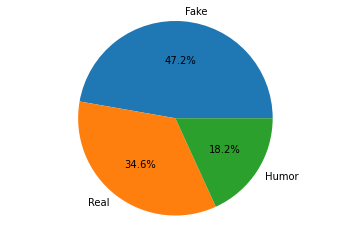

In [24]:
counts = [6841, 5009, 2633]
my_labels = 'Fake', 'Real', 'Humor'
plt.pie(counts,labels=my_labels,autopct='%1.1f%%')
#plt.title('Label Distribution')
plt.axis('equal')
plt.show()

## Analysis of tweet contents

Create new features in the dataset from tweet text: number of characters in the tweet, number of words in the tweet
Also keep count of the frequency words appear throughout dataset.

In [25]:
from collections import Counter
hashtags = Counter()
wordList = Counter()
tweetWordCount = []
wordCounts = Counter()
tweetCharLength = []
charLengths = Counter()
#iterate through tweetText
#if a word starts with hashtag, check if in dictionary, update count if not
for tweet in training['tweetText']:
    tweetCharLength.append(len(tweet))
    charLengths[len(tweet)] += 1
    words = tweet.split()
    tweetWordCount.append(len(words))
    wordCounts[len(words)] +=1
    for word in words:
        wordList[word.lower()] +=1
        if word.lower().startswith('#'):
            hashtags[word.lower()] +=1
training['tweetCharLength'] = tweetCharLength
training['tweetWordCount'] = tweetWordCount
     

Text(0.5, 1.0, 'Histogram of tweet word counts of training dataset')

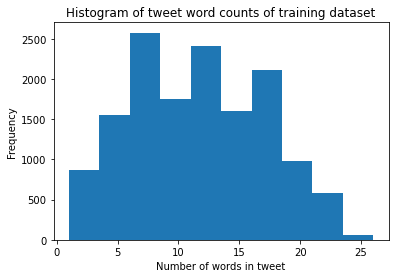

In [26]:
plt.hist(tweetWordCount, bins = 10)
plt.xlabel("Number of words in tweet")
plt.ylabel("Frequency")
plt.title('Histogram of tweet word counts of training dataset')

Text(0.5, 1.0, 'Histogram of tweet character counts')

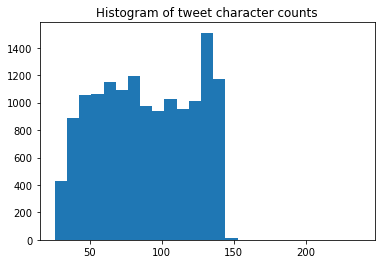

In [27]:
plt.hist(tweetCharLength, bins = 25)
plt.title('Histogram of tweet character counts')

In [28]:
wordList.most_common(10)

[('#sandy', 6424),
 ('the', 3794),
 ('sandy', 2870),
 ('of', 2738),
 ('in', 2587),
 ('a', 1954),
 ('is', 1785),
 ('hurricane', 1781),
 ('this', 1734),
 ('#hurricanesandy', 1573)]

Stop words and words related to hurricane sandy dominate the list, as you can see. This is something the classifier should consider in its design - perhaps through stopword removal and POS tagging.

Next use the langdetect library to calculate the language distribution

In [29]:
from langdetect import detect
languages = Counter()
tweetLang = []
unknown = 0
for tweet in training['tweetText']:
    try:
        l = detect(tweet)
        tweetLang.append(l)
        languages[l] +=1
    except:
        unknown += 1
        tweetLang.append("unknown")
training["tweetLanguage"] = tweetLang

In [30]:
languages.most_common()

[('en', 11139),
 ('es', 1300),
 ('tl', 312),
 ('fr', 217),
 ('id', 182),
 ('pt', 159),
 ('so', 130),
 ('de', 129),
 ('cy', 121),
 ('it', 100),
 ('nl', 93),
 ('ar', 80),
 ('af', 75),
 ('ru', 61),
 ('sv', 41),
 ('pl', 37),
 ('ca', 36),
 ('no', 35),
 ('tr', 34),
 ('da', 25),
 ('ja', 21),
 ('th', 18),
 ('fi', 17),
 ('sk', 15),
 ('vi', 12),
 ('sw', 11),
 ('zh-cn', 9),
 ('et', 9),
 ('bg', 8),
 ('ro', 8),
 ('sl', 8),
 ('hu', 6),
 ('ko', 6),
 ('sq', 5),
 ('lt', 5),
 ('el', 5),
 ('fa', 4),
 ('hr', 3),
 ('cs', 2),
 ('he', 1),
 ('mk', 1),
 ('hi', 1),
 ('lv', 1)]

## Comparing tweets by label

Split into real, fake and humor to see if there are any notable differences

In [31]:
fake_idx = training['label'] == 'fake'
fake_training = training[fake_idx].reset_index(drop=True)
real_idx = training['label'] == 'real'
real_training = training[real_idx].reset_index(drop=True)
humor_idx = training['label'] == 'humor'
humor_training = training[humor_idx].reset_index(drop=True)
humor_training.head()

tweetId                                          tweetText  \
0  264485305908883456  "Christie Blocks Sandy with Body, Saves Town"\...   
1  264454012848447489  Britain's last hurricane was devastating... ht...   
2  264694242096599040  wow, so funny, im on the floor, wow, u r cool ...   
3  264694652773482497  wow, so funny, im on the floor, wow, u r cool ...   
4  264329415276756993  Britain's last Hurricane was pretty devastatin...   

      userId      imageId(s)         username                       timestamp  \
0  781519416  sandyB_fake_12  RossRantsDotCom  Fri Nov 02 21:53:07 +0000 2012   
1  427742411  sandyB_fake_03   mialily_tudgee  Fri Nov 02 19:48:44 +0000 2012   
2  507779619  sandyB_fake_03       c0nditions  Sat Nov 03 11:43:19 +0000 2012   
3  191200490  sandyB_fake_03    taylorbonnd12  Sat Nov 03 11:44:57 +0000 2012   
4  175860415  sandyB_fake_03    kirstyhoylexo  Fri Nov 02 11:33:38 +0000 2012   

   label  tweetCharLength  tweetWordCount tweetLanguage  
0  humor              115               9            en  
1  humor               64               6            en  
2  humor              137              20            en  
3  humor              137              20            en  
4  humor               71               7            en

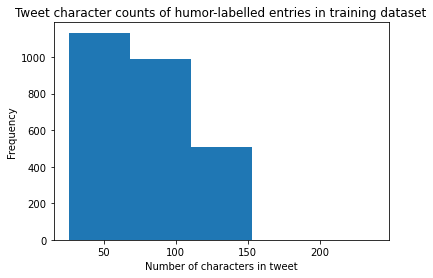

In [32]:
#plot distribution of word counts amongst real, fake, and humor splits
#tweets with humor label tend to be much shorter compared to the others
#real and fake are similar but real peaks a bit earlier
#distribution of number of character lengths in tweet tells a similar story
plt.hist(humor_training['tweetCharLength'], bins = 5)
plt.xlabel("Number of characters in tweet")
plt.ylabel("Frequency")
plt.title('Tweet character counts of humor-labelled entries in training dataset')
plt.show()
plt.hist(fake_training['tweetCharLength'], bins = 10)
plt.xlabel("Number of characters in tweet")
plt.ylabel("Frequency")
plt.title('Tweet character counts of fake-labelled entries in training dataset')
plt.show()
plt.hist(real_training['tweetCharLength'], bins = 10)
plt.xlabel("Number of characters in tweet")
plt.ylabel("Frequency")
plt.title('Tweet character lengths of real-labelled entries in training dataset')
plt.show()
plt.hist(training['tweetCharLength'], bins = 10)
plt.xlabel("Number of characters in tweet")
plt.ylabel("Frequency")
plt.title('Tweet character lengths of entries in training dataset')
plt.show()

Main takeaway here is that humor tweets tend to be much shorter compared to the other classes

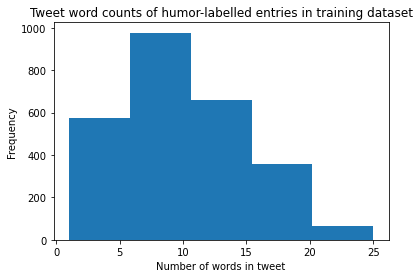

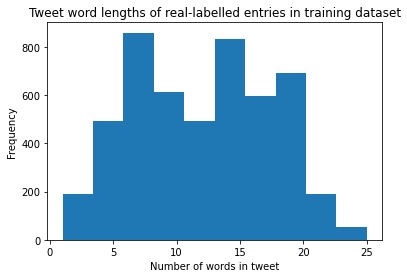

In [33]:
plt.hist(humor_training['tweetWordCount'], bins = 5)
plt.xlabel("Number of words in tweet")
plt.ylabel("Frequency")
plt.title('Tweet word counts of humor-labelled entries in training dataset')
plt.show()
plt.hist(fake_training['tweetWordCount'], bins = 10)
plt.xlabel("Number of words in tweet")
plt.ylabel("Frequency")
plt.title('Tweet word counts of fake-labelled entries in training dataset')
plt.show()
plt.hist(real_training['tweetWordCount'], bins = 10)
plt.xlabel("Number of words in tweet")
plt.ylabel("Frequency")
plt.title('Tweet word lengths of real-labelled entries in training dataset')
plt.show()
plt.hist(training['tweetWordCount'], bins = 10)
plt.xlabel("Number of words in tweet")
plt.ylabel("Frequency")
plt.title('Tweet word lengths of entries in training dataset')
plt.show()